In [276]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import ElasticNet
# from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from utils_data_structures import col_prefixes

In [277]:
grouped_df = pd.read_csv('sorare_data/small_test_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)

print(grouped_df['So_5_Scores_9'].isna().sum())

0


In [278]:
goalkeepers_df = grouped_df[grouped_df['Position'] == 'Goalkeeper']
goalkeepers_df = goalkeepers_df.drop(columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club'])

en_goalkeepers_df = goalkeepers_df
# goalkeepers_df = goalkeepers_df[:len(grouped_df) // 3]
goalkeepers_df = goalkeepers_df[:len(grouped_df) // 7]
len(goalkeepers_df)


79

In [279]:
goalkeepers_df.dtypes.value_counts()

float64    308
int64        4
Name: count, dtype: int64

In [280]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = goalkeepers_df.drop(columns=columns_to_drop)
y = goalkeepers_df[target_column]

In [281]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [282]:
# Initialize the XGBoost regressor
xgb_model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=3, subsample=0.6, colsample_bytree=0.8, gamma=0.1, reg_alpha= 1.0, reg_lambda= 100.0 , random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
y_pred_xgb_clipped = np.clip(y_pred_xgb, 0, 100)
mse = mean_squared_error(y_test, y_pred_xgb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_xgb_clipped)
print(f'r2: {r2}')

RMSE: 11.219992136067273
r2: 0.7004092146788776


In [283]:
# Best Parameters: {'subsample': 0.5, 'num_leaves': 20, 'n_estimators': 400, 'min_child_samples': 10, 'max_depth': 10, 'learning_rate': 0.01}
# Initialize the LightGBM regressor
lgbm_model = lgb.LGBMRegressor(
    boosting_type='gbdt',  # Gradient boosting decision tree
    n_estimators=400,      # Number of boosting rounds (trees)
    learning_rate=0.01,     # Step size shrinkage
    max_depth=10,          # Unlimited depth of trees (-1 means no limit)
    random_state=42,
)

# Train the model
lgbm_model.fit(X_train, y_train)
# Make predictions
y_pred_lgbm = lgbm_model.predict(X_test)

# Evaluate
y_pred_lgmb_clipped = np.clip(y_pred_lgbm, 0, 100)
mse = mean_squared_error(y_test, y_pred_lgmb_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_lgmb_clipped)
print(f'r2: {r2}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 276
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 36
[LightGBM] [Info] Start training from score 15.966667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [284]:
# Best alpha: 0.451
# alpha=0.05
# Best l1_ratio: 0.9
# Initialize ElasticNet
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred_en = elastic_model.predict(X_test)

# Evaluate
y_pred_en_clipped = np.clip(y_pred_en, 0, 100)
mse = mean_squared_error(y_test, y_pred_en_clipped)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')

RMSE: 14.910041746599061
r2: 0.47094470515947173


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.085e+03, tolerance: 4.090e+00
  model = cd_fast.enet_coordinate_descent(


In [285]:
with open('sorare_models/goalkeepers_xgb_model.pkl', 'wb') as file:
    pickle.dump(xgb_model, file)
    print("XGB Model saved successfully!")
with open('sorare_models/goalkeepers_lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)
    print("LGBM Model saved successfully!")

with open('sorare_models/goalkeepers_elastic_model.pkl', 'wb') as file:
    pickle.dump(elastic_model, file)
    print("Elastic Model saved successfully!")

print("Models saved successfully!")

XGB Model saved successfully!
LGBM Model saved successfully!
Elastic Model saved successfully!
Models saved successfully!


In [286]:
y_test_df = pd.DataFrame(y_test)
y_test_df['XBG_Predictions'] = y_pred_xgb_clipped
y_test_df['LGBM_Predictions'] = y_pred_lgmb_clipped
y_test_df['EN_Predictions'] = y_pred_en_clipped
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions
216,0.0,1.868687,0.000000,7.377668
2,0.0,3.471300,7.633076,10.339078
158,0.0,4.449108,3.291801,7.345106
225,0.0,5.130188,5.785827,20.320002
146,0.0,1.339266,0.000000,10.879188
191,0.0,4.940215,6.421136,0.000000
52,37.8,32.050175,44.296350,53.291534
636,0.0,3.427413,6.434237,2.883158
26,0.0,2.468695,7.913369,7.861454
65,70.0,32.459034,44.855930,100.000000


In [287]:
y_test_df['Average_Prediction'] = (y_test_df['XBG_Predictions'] + y_test_df['LGBM_Predictions'] + y_test_df['EN_Predictions']) / 3
y_test_df

,So_5_Scores_9,XBG_Predictions,LGBM_Predictions,EN_Predictions,Average_Prediction
216,0.0,1.868687,0.000000,7.377668,3.082118
2,0.0,3.471300,7.633076,10.339078,7.147818
158,0.0,4.449108,3.291801,7.345106,5.028672
225,0.0,5.130188,5.785827,20.320002,10.412006
146,0.0,1.339266,0.000000,10.879188,4.072818
191,0.0,4.940215,6.421136,0.000000,3.787117
52,37.8,32.050175,44.296350,53.291534,43.212686
636,0.0,3.427413,6.434237,2.883158,4.248269
26,0.0,2.468695,7.913369,7.861454,6.081173
65,70.0,32.459034,44.855930,100.000000,59.104988


In [288]:
y_true = y_test_df['So_5_Scores_9'].to_numpy()
y_pred = y_test_df['Average_Prediction'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'RMSE: {rmse}')
r2 = r2_score(y_test, y_pred_en_clipped)
print(f'r2: {r2}')

RMSE: 7.410750816881215
r2: 0.47094470515947173


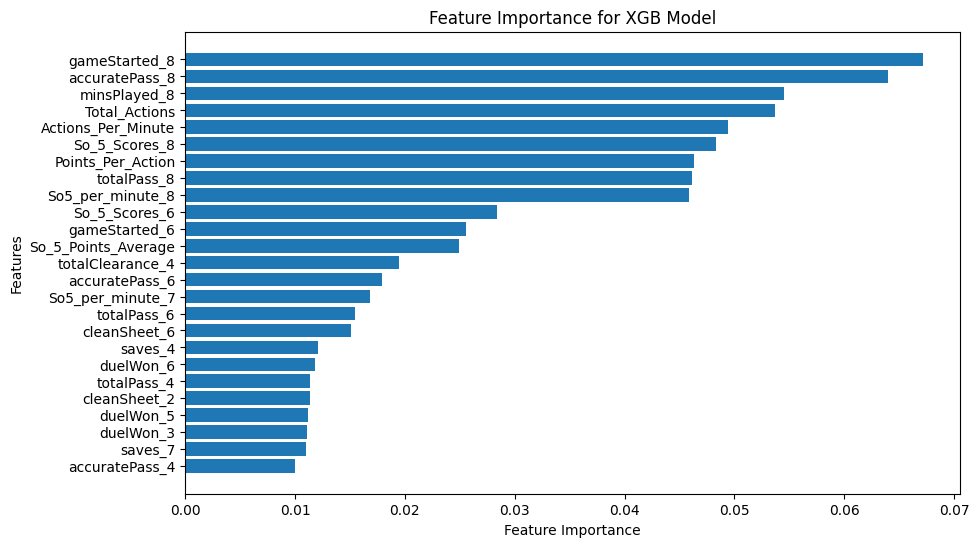

In [289]:
# Get feature importances
importances = xgb_model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

top_n = 25  # Number of top features to show
top_features = feature_importance_df.nlargest(top_n, 'Importance')

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance for XGB Model')
plt.gca().invert_yaxis()
plt.show()

In [290]:
epl_teams = pd.read_csv('sorare_data/large_cleaned_sorare_data.csv')

epl_teams = epl_teams.fillna(0.0)

epl_goalkeepers_df = epl_teams[epl_teams['Position'] == 'Goalkeeper']

epl_goalkeepers_df = epl_goalkeepers_df.reset_index(drop=True)


In [291]:
drop_columns = columns=['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club']

columns_to_drop = [f'{col}_9' for col in col_prefixes]
columns_to_drop.extend(drop_columns)

target_column = 'So_5_Scores_9'

X_test_goalkeepers = epl_goalkeepers_df.drop(columns=columns_to_drop)
y_test_goalkeepers = epl_goalkeepers_df[target_column]

In [292]:
with open('sorare_models/goalkeepers_xgb_model.pkl', 'rb') as file:
    goalkeepers_xgb_model_loaded = pickle.load(file)
    print("XGB Model loaded successfully!")
with open('sorare_models/goalkeepers_lgbm_model.pkl', 'rb') as file:
    goalkeepers_lgbm_model_loaded = pickle.load(file)
    print("LGBM Model loaded successfully!")
with open('sorare_models/goalkeepers_elastic_model.pkl', 'rb') as file:
    goalkeepers_elastic_model_loaded = pickle.load(file)
    print("Elastic Model loaded successfully!")

XGB Model loaded successfully!
LGBM Model loaded successfully!
Elastic Model loaded successfully!


In [293]:
xgb_predictions = goalkeepers_xgb_model_loaded.predict(X_test_goalkeepers)
lgbm_predictions = goalkeepers_lgbm_model_loaded.predict(X_test_goalkeepers)
elastic_predictions = goalkeepers_elastic_model_loaded.predict(X_test_goalkeepers)

xgb_predictions = np.clip(xgb_predictions, 0, 100)
lgbm_predictions = np.clip(lgbm_predictions, 0, 100)
elastic_predictions = np.clip(elastic_predictions, 0, 100)

y_test_goalkeepers_df = pd.DataFrame(y_test_goalkeepers)

epl_goalkeepers_df['sorare_xgb_predictions'] = pd.Series(xgb_predictions)
epl_goalkeepers_df['sorare_lgbm_predictions'] = pd.Series(lgbm_predictions)
epl_goalkeepers_df['sorare_elastic_predictions'] = pd.Series(elastic_predictions)

epl_goalkeepers_df['sorare_predictions'] = epl_goalkeepers_df[['sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].mean(axis=1)

epl_goalkeepers_df[['So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions']].head(3)

,So_5_Scores_9,sorare_xgb_predictions,sorare_lgbm_predictions,sorare_elastic_predictions
0,0.0,3.229879,11.612988,0.000000
1,45.2,27.165403,36.556783,48.727754
2,0.0,3.359521,7.913369,6.681684


In [294]:
y_true = epl_goalkeepers_df['So_5_Scores_9'].to_numpy()
y_pred = epl_goalkeepers_df['sorare_predictions'].to_numpy()

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f'MSE: {mean_squared_error(y_true, y_pred)}')
print(f'RMSE: {rmse}')
r2 = r2_score(y_true, y_pred)
print(f'r2: {r2}')

MSE: 291.3182534418035
RMSE: 17.068047733756885
r2: 0.6046438485346979


In [295]:
xgb_scores = cross_val_score(goalkeepers_xgb_model_loaded, X, y)
lgbm_scores = cross_val_score(goalkeepers_lgbm_model_loaded, X, y)
elastic_scores = cross_val_score(goalkeepers_elastic_model_loaded, X, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 130
[LightGBM] [Info] Number of data points in the train set: 63, number of used features: 11
[LightGBM] [Info] Start training from score 11.592064
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.934e+02, tolerance: 3.201e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.102e+03, tolerance: 4.218e+00
  model = cd_fast.enet_coordinate_descent(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might

In [296]:
print("XGBoost scores:", xgb_scores)
print("Mean XGBoost score:", xgb_scores.mean())

print("LGBM scores:", lgbm_scores)
print("Mean LGBM score:", lgbm_scores.mean())

print("Elastic scores:", elastic_scores)
print("Mean Elastic score:", elastic_scores.mean())

XGBoost scores: [0.1220997  0.71792756 0.6259663  0.2832945  0.25892018]
Mean XGBoost score: 0.4016416493680988
LGBM scores: [0.47404994 0.7516597  0.56965244 0.05717682 0.27899837]
Mean LGBM score: 0.42630745411105886
Elastic scores: [ 0.04408708 -0.13096647  0.10864001 -0.60515464 -0.24833482]
Mean Elastic score: -0.16634576529681028


In [297]:
saved_goalkeepers_df = epl_goalkeepers_df[['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position', 'Current_Club','So_5_Scores_9','sorare_xgb_predictions', 'sorare_lgbm_predictions', 'sorare_elastic_predictions', 'sorare_predictions']]
# saved_goalkeepers_df.to_csv('sorare_data/predictions/sorare_goalkeepers_predictions.csv', index=False)